## Don't Get Kicked!

The challenge is to predict if a car purchased at the Auction is a Kick (bad buy).

- ** Software and Libraries**

This project uses the following software and Python libraries:

- Python 3.5
- Numpy
- Pandas
- sklearn
- matplotlib
- seaborn
- scipy
- Jupyter Notebook
- imblearn
- geopy
- Basemap
- math


In [1]:
%matplotlib inline

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('./training.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72983 entries, 0 to 72982
Data columns (total 34 columns):
RefId                                72983 non-null int64
IsBadBuy                             72983 non-null int64
PurchDate                            72983 non-null object
Auction                              72983 non-null object
VehYear                              72983 non-null int64
VehicleAge                           72983 non-null int64
Make                                 72983 non-null object
Model                                72983 non-null object
Trim                                 70623 non-null object
SubModel                             72975 non-null object
Color                                72975 non-null object
Transmission                         72974 non-null object
WheelTypeID                          69814 non-null float64
WheelType                            69809 non-null object
VehOdo                               72983 non-null int64
Nationalit

### Train-Test Split

The data is split into train and test datasets in a stratified fashion using the target label. The training dataset includes 75% of the original dataset. 

In [3]:
from sklearn.cross_validation import train_test_split

y = df['IsBadBuy']
X = df.drop('IsBadBuy',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 33) 

### Feature Engineering:

The number of missing values in each column of the training and test datasets are as follows:

In [4]:
print ('Shape of X_train is: (%i,%i) \n' % X_train.shape)
X_train.isnull().sum()

Shape of X_train is: (54737,33) 



RefId                                    0
PurchDate                                0
Auction                                  0
VehYear                                  0
VehicleAge                               0
Make                                     0
Model                                    0
Trim                                  1757
SubModel                                 5
Color                                    5
Transmission                             6
WheelTypeID                           2398
WheelType                             2402
VehOdo                                   0
Nationality                              4
Size                                     4
TopThreeAmericanName                     4
MMRAcquisitionAuctionAveragePrice       11
MMRAcquisitionAuctionCleanPrice         11
MMRAcquisitionRetailAveragePrice        11
MMRAcquisitonRetailCleanPrice           11
MMRCurrentAuctionAveragePrice          234
MMRCurrentAuctionCleanPrice            234
MMRCurrentR

In [5]:
print ('Shape of X_test is: (%i,%i) \n' % X_test.shape)
X_test.isnull().sum()

Shape of X_test is: (18246,33) 



RefId                                    0
PurchDate                                0
Auction                                  0
VehYear                                  0
VehicleAge                               0
Make                                     0
Model                                    0
Trim                                   603
SubModel                                 3
Color                                    3
Transmission                             3
WheelTypeID                            771
WheelType                              772
VehOdo                                   0
Nationality                              1
Size                                     1
TopThreeAmericanName                     1
MMRAcquisitionAuctionAveragePrice        7
MMRAcquisitionAuctionCleanPrice          7
MMRAcquisitionRetailAveragePrice         7
MMRAcquisitonRetailCleanPrice            7
MMRCurrentAuctionAveragePrice           81
MMRCurrentAuctionCleanPrice             81
MMRCurrentR

#### Notes:

1. About 95% of data is missing in `PRIMEUNIT` and `AUCGUART` columns. Therefore, they are removed from datasets.
2. The missing values in `Transmission` are replaced with the most frequent category i.e. 'AUTO'.
3. The missing values in `Color` are replaced with 'NOT AVAIL' which is one of the existing labels for color.
4. The missing values of `SubModel` in the training dataset are removed. The only missing value in the test dataset is replaced with 'Unknown'.
5. The missing values of `Size` are found using the information in the test dataset based on `Make` and `Model` of the vehicle. 
6. The missing values of `Nationality` and `TopThreeAmericanName` are found using the information in the test dataset. 
7. The missing values of `WheelTypeID` are replaced with 0.0, which already exist for some samples with missing `WheelType`. Additionally, `WheelType` is redundant and is removed from the dataset. 
8. The possible options for `Trim` are found using the `Make`, `Model`, and `SubModel` in the training dataset. Then the most frequent trim type is assigned to the missing values.
9. To fill in the missing values in acquisition prices, the prices for similar vehicles are found using `Make`, `Model`, `VehicleAge`, and `Size` information in the training dataset. Then the missing values are replaced with the median value of the matching vehicle type. 


In [6]:
# Remove 'RefId' 'PRIMEUNIT' and 'AUCGUART'.
X_train = X_train.drop(['RefId','PRIMEUNIT','AUCGUART'],axis=1)
X_test = X_test.drop(['RefId','PRIMEUNIT','AUCGUART'],axis=1)



# Convert purchase date to int type
for dfn in [X_train, X_test]:
    dfn.PurchDate = pd.to_datetime(dfn.PurchDate,format=r'%m/%d/%Y').astype(np.int64)//10**10

    
# Replace missing values in Transmission with Auto and Color to 'NOT AVAIL'
def singleValueImputer(df,colname,val):
    '''Converts all strings to uppercase and replaces na with val'''
    df[colname] = df[colname].str.upper()
    df[colname] = df[colname].fillna(val)
    return df

impute_list = [('Transmission','AUTO'),('Color','NOT AVAIL')]

for t in impute_list:
    X_train = singleValueImputer(X_train,t[0],t[1])
    X_test = singleValueImputer(X_test,t[0],t[1])


# Remove samples with missing values in SubModel
mask_train = X_train.SubModel.notnull()
X_train = X_train.loc[mask_train,:].copy()
X_test.SubModel.fillna('Unknown',inplace=True)
y_train = y_train[mask_train].copy()


# Impute size
def imputeSize(df,df_train):
    '''Finds the Size using Make and Model in training data otherwise "unknown"'''
    S = df.loc[df.Size.isnull(),['Make','Model']]
    for index , make , model in S.itertuples():
        size = df_train.loc[((df_train.Make==make) & (df_train.Model==model) & df_train.Size.notnull()),'Size'].unique()
        if len(size)==1:
            df.loc[int(index),'Size'] = size[0]
        else:
            df.loc[int(index),'Size'] = 'Unknown'
    return df

X_train = imputeSize(X_train,X_train)
X_test = imputeSize(X_test,X_train)


# Impute Nationality and TopThreeAmericanName
def imputeNationality_Top3(df,df_train,colname):
    '''Only use for Nationality and TopThreeAmericanName'''
    S = df.loc[df[colname].isnull(),['Make']]
    for index, make in S.itertuples():
        name = df_train.loc[(df_train[colname].notnull() & (df_train.Make==make)), colname].unique()[0]
        if name:
            df.loc[int(index),colname] = name
    return df

impute_list = ['Nationality','TopThreeAmericanName']
for name in impute_list:
    X_train = imputeNationality_Top3(X_train,X_train,name)
    X_test = imputeNationality_Top3(X_test,X_train,name)

    
# Impute WheelType and remove WheelTypeID
for dfn in [X_train,X_test]:
    dfn.WheelTypeID.fillna(0.0,inplace=True)
    dfn.drop('WheelType',axis=1, inplace=True)

# Impute Trim using the information from Make, Model, and SubModel.
def imputeTrim(df,df_train):
    '''Imputes the missing values int the Trim column'''
    S = df.loc[df.Trim.isnull(),['Make','Model','SubModel']]
    for index, make, model, submodel in S.itertuples():
        trims = (df_train.loc[(df_train.Make==make) & (df_train.Model==model) & (df_train.SubModel==submodel) &
                              (df_train.Trim.notnull()),'Trim']).value_counts()
        if len(trims) > 0:
            df.loc[int(index),'Trim'] = trims.argmax()
        else:
            df.loc[int(index),'Trim'] = 'Unknown'
    return df

for dfn in [X_train,X_test]:
    dfn = imputeTrim(dfn,X_train)

    
# Impute missing prices
def imputeMMR(df,df_train,colname):
    '''Imputes the missing values of Acquisition prices'''
    S = df.loc[df[colname].isnull(),['Make','Model','VehicleAge','Size']]
    for index, make, model, age, size in S.itertuples():
        val = df_train.loc[(df_train.Make==make) & (df_train.Model==model) & (df_train[colname].notnull()) &
                           (df_train.VehicleAge==age),colname].quantile()
        if np.isfinite(val):
            df.loc[int(index),colname] = val
        else:
            val = df_train.loc[(df_train.Make==make) & (df_train.Size==size) & (df_train[colname].notnull()) 
                               & (df_train.VehicleAge==age),colname].quantile()
            df.loc[int(index),colname] = val
    return df 

colnames = ['MMRAcquisitionAuctionAveragePrice','MMRAcquisitionAuctionCleanPrice','MMRAcquisitionRetailAveragePrice',
           'MMRAcquisitonRetailCleanPrice','MMRCurrentAuctionAveragePrice','MMRCurrentAuctionCleanPrice',
           'MMRCurrentRetailAveragePrice','MMRCurrentRetailCleanPrice']
for colname in colnames:
    X_train = imputeMMR(X_train,X_train,colname)
    X_test = imputeMMR(X_test,X_train,colname)

In [7]:
# drop the last missing row in the training data
mask = X_train.MMRCurrentAuctionCleanPrice.notnull()
X_train = X_train.loc[mask,:]
y_train = y_train[mask]

In [8]:
print ('Is there any null value in the training dataset?   %s' % (X_test.isnull().any()).any())
print ('Is there any null value in the test dataset?       %s' % (X_test.isnull().any()).any())

Is there any null value in the training dataset?   False
Is there any null value in the test dataset?       False


### Data Exploration

The following pie chart shows that the dataset is imbalanced and the prevalence of the majority class is 87.7%.

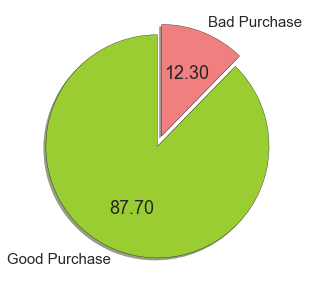

In [9]:
sns.set_context('notebook',font_scale=1.5)
labels =['Good Purchase','Bad Purchase']
colors = ['yellowgreen', 'lightcoral']
explode = (0, 0.1)
plt.figure(figsize=(5,5))
plt.pie(y_train.value_counts(),labels=labels,colors=colors,explode=explode, shadow=True, startangle=90, autopct='%.2f');

In [10]:
sns.set(font_scale=1.25)
plt.rcParams['figure.figsize']=(14,5);
def crosstab_barplot(df,target,feature,plot_type='count',verbose = False,log_scale = False):
    '''Plots a bar chart for the given feature. The bar chart could be in the type of 
    "count value" and "percentage". It is also possible to plot in log-scale '''
    ctab = pd.crosstab(df[feature],target.astype(bool))
    if verbose:
        print (ctab)
    if plot_type == 'count':
        ctab.plot.bar(log=log_scale)
        plt.ylabel('Count');
    elif plot_type == 'percentage':
        s = ctab.iloc[:,1]/ctab.sum(axis=1)*100
        df = pd.DataFrame([s,100-s],index=['True','Flase']).transpose()
        df.plot.bar(log=log_scale)
        plt.ylabel('Percentage')
        plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1, title=ctab.columns.name)
    plt.title(feature + ' vs Purchase Result')
    
    return ctab

In [11]:
colors = ['yellowgreen', 'lightcoral']
def plotPieChart(df,target,feature,figsize,c,nrows=1,ncols=2,txt=''):
    '''Plots pie charts for a given feature'''
    ctab = pd.crosstab(df[feature],target.astype(bool))
    m,n = ctab.shape
    plt.figure()
    labels =['Good Purchase','Bad Purchase']
    colors = c
    explode = (0, 0.1)
    plt.figure(figsize=figsize)
    for i in range(m):
        plt.subplot(nrows,ncols,i+1)
        plt.title(str(ctab.index[i])+txt)
        plt.pie(ctab.iloc[i,:],labels=labels,colors=colors,explode=explode, shadow=True, startangle=90, autopct='%.2f');
    plt.suptitle(feature + ' vs Purchase Result', y=1.05);
    return ctab

The following bar chart and table show that the purchased vehicles from specific brands such as `Volvo` were rarely a kick! However, it should be considered that the number of vehicles purchased varies considerably among different brands. 

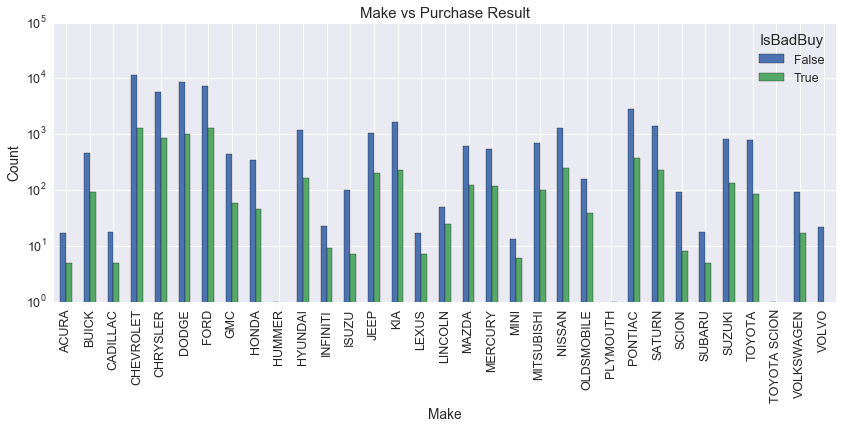

In [12]:
ctab = crosstab_barplot(X_train,y_train,'Make',log_scale=True)

In [14]:
# value count of targets fot each beand ('Make')
ctab['percentage'] = ctab.iloc[:,1]/ctab.sum(axis=1)*100
print(ctab)

IsBadBuy      False  True  percentage
Make                                 
ACURA            17     5   22.727273
BUICK           455    91   16.666667
CADILLAC         18     5   21.739130
CHEVROLET     11672  1273    9.833913
CHRYSLER       5775   844   12.751171
DODGE          8682   997   10.300651
FORD           7148  1308   15.468307
GMC             434    58   11.788618
HONDA           339    45   11.718750
HUMMER            1     0    0.000000
HYUNDAI        1189   163   12.056213
INFINITI         23     9   28.125000
ISUZU           101     7    6.481481
JEEP           1070   198   15.615142
KIA            1655   224   11.921235
LEXUS            17     7   29.166667
LINCOLN          50    25   33.333333
MAZDA           615   121   16.440217
MERCURY         551   117   17.514970
MINI             13     6   31.578947
MITSUBISHI      691    99   12.531646
NISSAN         1301   243   15.738342
OLDSMOBILE      158    38   19.387755
PLYMOUTH          0     1  100.000000
PONTIAC     

The following pie chart shows that Older vehicles are more likely to be a kicked car. 

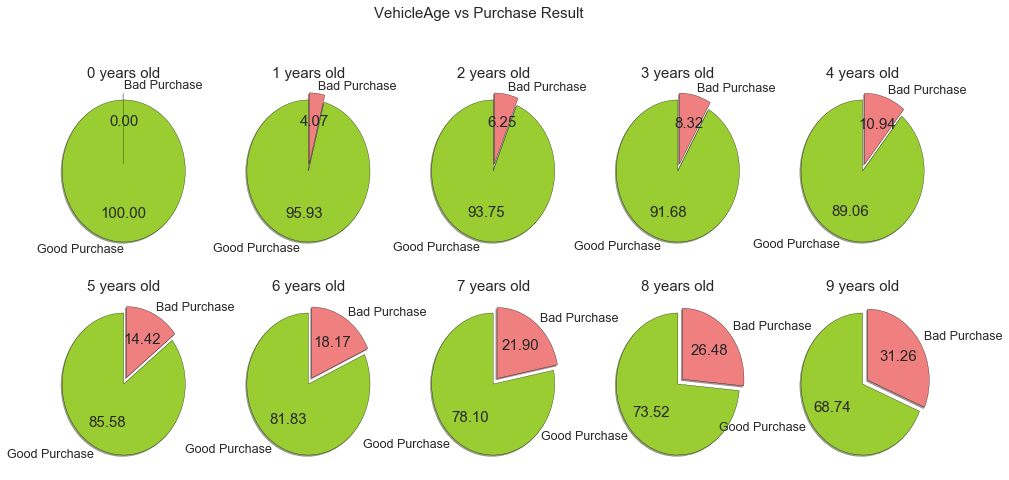

In [15]:
Ctab = plotPieChart(X_train,y_train,'VehicleAge',(16,7),colors,nrows=2,ncols=5,txt=' years old')

There is no significant correlation between the types of `Transmission`, `Nationality`, `TopThreeAmericanName` and `Size` of the vehicles with a higher risk of being a kick vehicle. Therefore, these features do not seem to provide useful information for predicting the desired target.

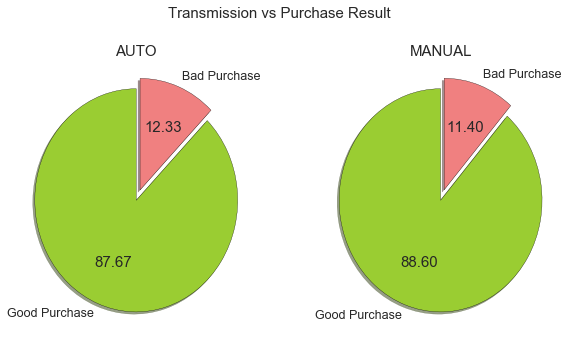

In [16]:
Ctab = plotPieChart(X_train,y_train,'Transmission',(10,5),colors)

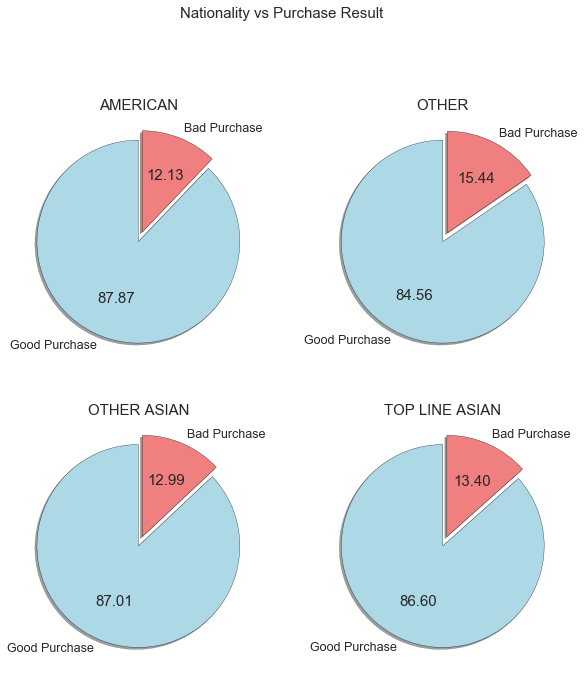

In [16]:
colors = ['lightblue', 'lightcoral']
Ctab = plotPieChart(X_train,y_train,'Nationality',(10,10),colors,nrows=2,ncols=2)

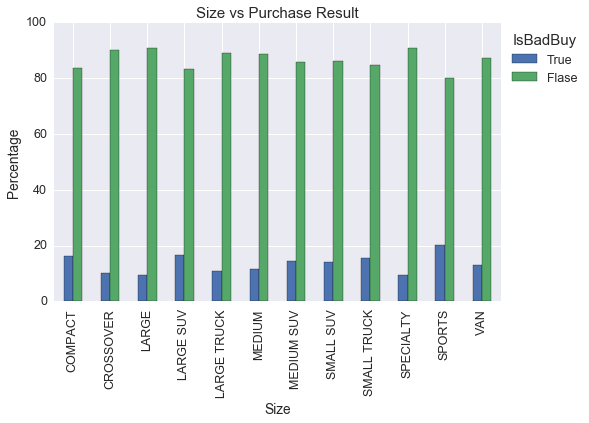

In [17]:
plt.rcParams['figure.figsize']=(8,5);
Ctab = crosstab_barplot(X_train,y_train,'Size',plot_type='percentage')

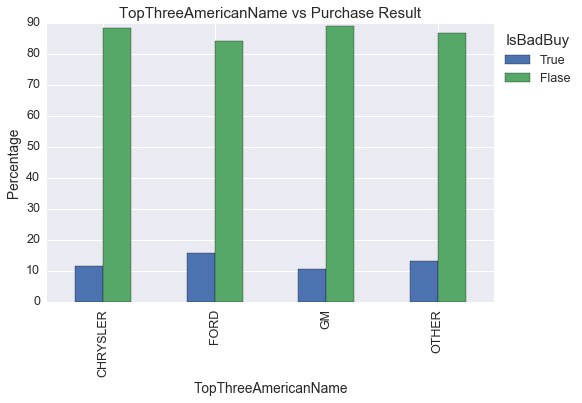

In [18]:
Ctab = crosstab_barplot(X_train,y_train,'TopThreeAmericanName',plot_type='percentage')

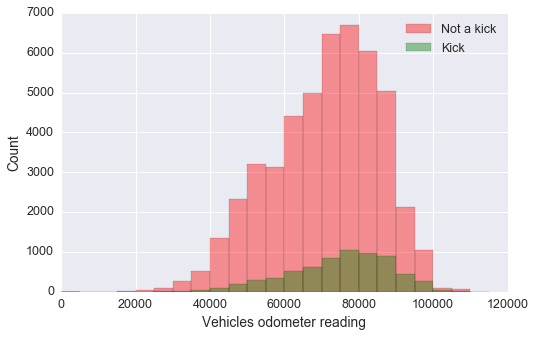

In [19]:
plt.rcParams['figure.figsize']=(8,5);
bins = np.arange(0,120000,5000);
kicked = X_train[y_train == 1]['VehOdo'].reset_index(drop=True);
notkicked = X_train[y_train == 0]['VehOdo'].reset_index(drop=True);
plt.hist(notkicked,bins=bins, color='red',alpha=0.4, label='Not a kick');
plt.hist(kicked,bins=bins, color='green',alpha=0.4, label = 'Kick');
plt.xlabel('Vehicles odometer reading')
plt.ylabel('Count');
plt.legend(loc='best');
plt.savefig('odometer', dpi=None, facecolor='w', edgecolor='w', bbox_inches= 'tight')

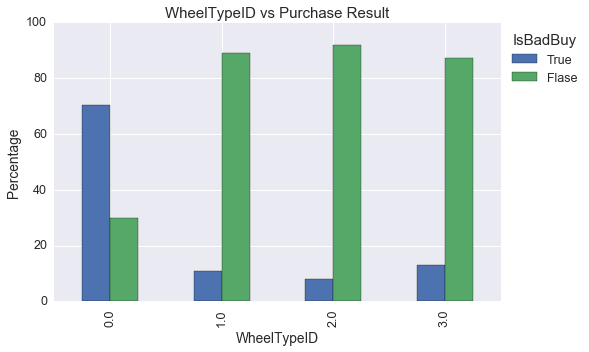

In [20]:
ctab = crosstab_barplot(X_train,y_train,'WheelTypeID',plot_type='percentage',log_scale=False)
plt.savefig('Make', dpi=None, facecolor='w', edgecolor='w', bbox_inches= 'tight')
plt.savefig('WheelTypeID', dpi=None, facecolor='w', edgecolor='w', bbox_inches= 'tight')

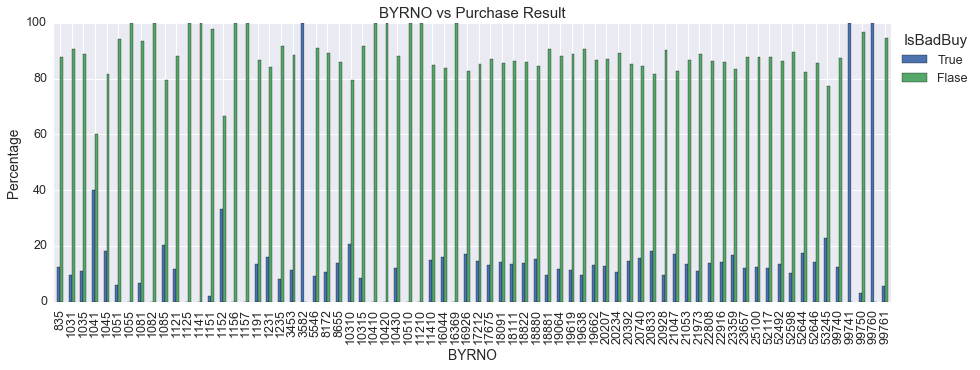

In [21]:
plt.rcParams['figure.figsize']=(15,5);
Ctab = crosstab_barplot(X_train,y_train,'BYRNO',plot_type='percentage')
plt.savefig('BYRNO', dpi=None, facecolor='w', edgecolor='w', bbox_inches= 'tight')

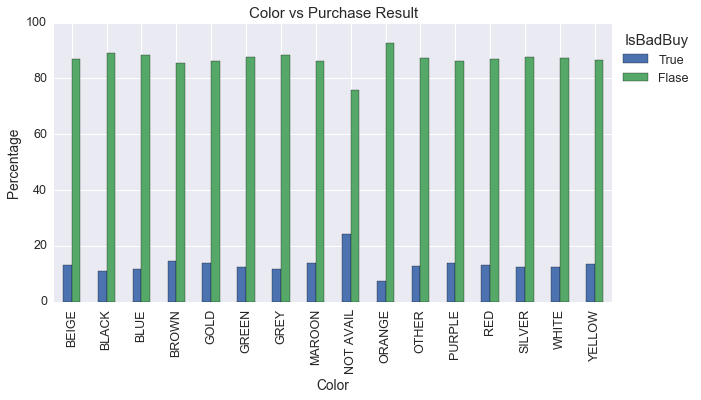

In [22]:
plt.rcParams['figure.figsize']=(10,5);
Ctab = crosstab_barplot(X_train,y_train,'Color',plot_type='percentage')
plt.savefig('color', dpi=None, facecolor='w', edgecolor='w', bbox_inches= 'tight')

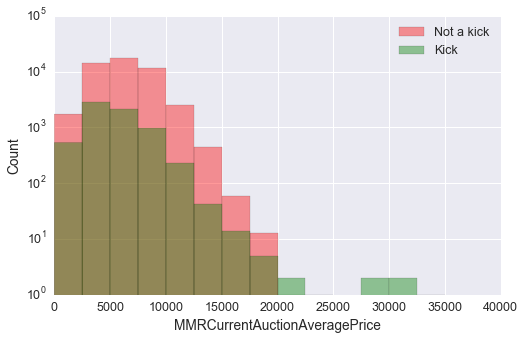

In [23]:
plt.rcParams['figure.figsize']=(8,5);
bins = np.arange(0,40000,2500);
kicked = X_train[y_train == 1]['MMRCurrentAuctionAveragePrice'].reset_index(drop=True);
notkicked = X_train[y_train == 0]['MMRCurrentAuctionAveragePrice'].reset_index(drop=True);
plt.hist(notkicked,bins=bins, log=True, color='red',alpha=0.4, label='Not a kick');
plt.hist(kicked,bins=bins, log=True, color='green',alpha=0.4, label = 'Kick');
plt.xlabel('MMRCurrentAuctionAveragePrice')
plt.ylabel('Count');
plt.legend(loc='best');
plt.savefig('MMRCurrentAuctionAveragePrice', dpi=None, facecolor='w', edgecolor='w', bbox_inches= 'tight')

In [24]:
states_dict = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}

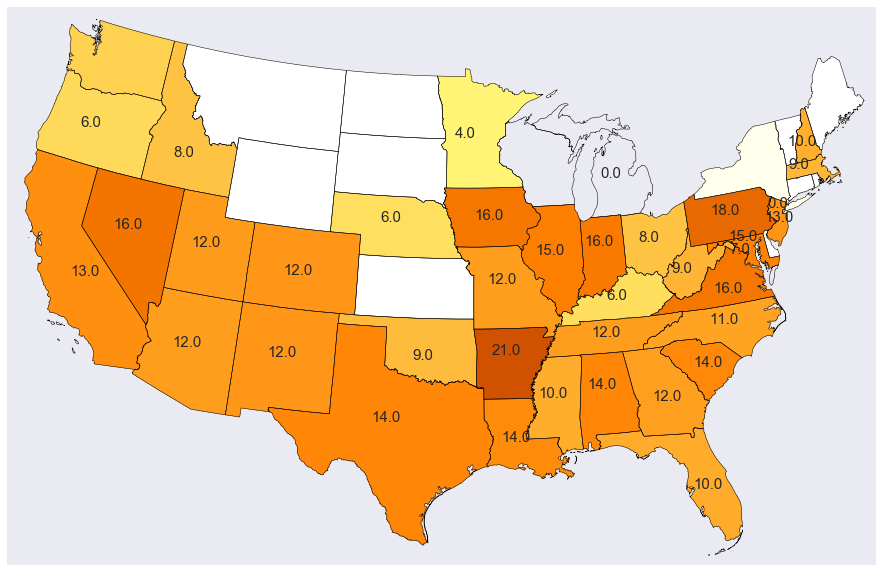

In [26]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from geopy.geocoders import Nominatim
from matplotlib.patches import Polygon
import math
import sys


map = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=32,lat_2=45,lon_0=-95)

fig = plt.figure(figsize=(18,10))

map.readshapefile('st99_d00', name='states', drawbounds=True)

ctab = pd.crosstab(X_train.VNST,y_train.astype(bool))
ctab['percentage'] = ctab.iloc[:,1]/ctab.sum(axis=1)*100
state_names = []
for shape_dict in map.states_info:
    state_names.append(shape_dict['NAME'])


states = set(state_names)
ax = plt.gca()
cmap = plt.cm.afmhot
colors={}
geolocator = Nominatim()

others = ['District of Columbia','Puerto Rico']
for state in states:
    seg = map.states[state_names.index(state)]
    loc = geolocator.geocode(state)
    x, y = map(loc.longitude, loc.latitude)
    if state  in others:
        continue
    if states_dict[state] not in ctab.index:
        poly = Polygon(seg, facecolor='w',edgecolor='w')
        ax.add_patch(poly)
        continue
    colors[state] = cmap(1.-math.sqrt((ctab.loc[states_dict[state],'percentage']+0.1)/60))[:3]
    ax.annotate(str(round(ctab.loc[states_dict[state],'percentage'])),xy=(x-100000,y))
    poly = Polygon(seg, facecolor=colors[state],edgecolor=colors[state])
    ax.add_patch(poly)
    

### Encoding Categorical Data

The categorical variables must be encoded to numerical values before using sklean estimators. I used two types of encoding approaches:

1. Encoding using sklearn.preprocessing.LableEncoder()
2. Encoding using pandas.get_dummies()


**Challenges:**

In comparison with *one-hot encoding*, a simple LableEncoding leads to a less sparse data frame which is memory efficient. However, this form of encoding is not suitable when a linear estimator is used for modeling. Additionally, all the labels should exist in the training dataset, otherwise, it raises an error upon applying the encoder to the test dataset.

Pandas.get_dummies is similar to OneHotEncoder of sklearn. It can be easily applied to both train and test datasets. In the case of encountering an unseen label in the test dataset, we can be easily reset the indices the labels of the training data set.  

I am going to use a `RandomForestClassifier`. Therefore, I do not necessarily need to convert the data to a one-hot encoded form. However, as some unseen labels exist in the test set, a pandas.get_dummies is used for those columns.   

In [9]:
from collections import defaultdict

encoders = defaultdict(str)

def labelEncoder(df_train, df_test, colnames, encoders):
    '''This function uses the sklean encoders to convert categorical variables to
    integers between 0 and n_class-1. The encoders for features are collected in a 
    dictionary. 
    Note: All labels in test dataset must exist in training dataset.'''
    for colname in colnames:
        from sklearn.preprocessing import LabelEncoder
        encoders[colname] = LabelEncoder()
        encoders[colname].fit(df_train[colname])
        df_train[colname] = encoders[colname].transform(df_train[colname])
        df_test[colname] = encoders[colname].transform(df_test[colname])
    return df_train, df_test, encoders

columns = ['Auction', 'Make', 'Color', 'Transmission', 'Nationality',
            'Size', 'TopThreeAmericanName', 'VNST']

X_train, X_test, encoders = labelEncoder(X_train,X_test,columns,encoders)

In [10]:
encoders['Make'].classes_

array(['ACURA', 'BUICK', 'CADILLAC', 'CHEVROLET', 'CHRYSLER', 'DODGE',
       'FORD', 'GMC', 'HONDA', 'HUMMER', 'HYUNDAI', 'INFINITI', 'ISUZU',
       'JEEP', 'KIA', 'LEXUS', 'LINCOLN', 'MAZDA', 'MERCURY', 'MINI',
       'MITSUBISHI', 'NISSAN', 'OLDSMOBILE', 'PLYMOUTH', 'PONTIAC',
       'SATURN', 'SCION', 'SUBARU', 'SUZUKI', 'TOYOTA', 'TOYOTA SCION',
       'VOLKSWAGEN', 'VOLVO'], dtype=object)

In [11]:
columns = ['Model', 'SubModel', 'Trim']

def dummyEncoder(df_train, df_test, columns):
    '''OneHotEndoding of the categorical variables. This function resets labels  
    to those that were observed in the training data set'''
    for colname in columns:
        dummies_train = pd.get_dummies(df_train[colname])
        df_train = pd.concat([df_train, dummies_train], axis=1)
        df_train.drop(colname, axis=1, inplace=True)
        dummies_test = pd.get_dummies(df_test[colname])
        dummies_test = dummies_test.reindex(columns=dummies_train.columns, fill_value=0)
        df_test = pd.concat([df_test, dummies_test], axis=1)
        df_test.drop(colname, axis=1, inplace=True)
    return df_train, df_test

X_train, X_test = dummyEncoder(X_train, X_test, columns) 

In [12]:
print ('Shape of the training data set; ', X_train.shape)
print ('Shape of the test data set; ', X_test.shape)

Shape of the training data set;  (54731, 1984)
Shape of the test data set;  (18246, 1984)


## Modeling:

A **SelectKBest** feature selection and a **RandomForestClassifier** are embedded in a **pipeline**. The best_Kfeatures function performs a grid seach to find the k-best features. The hyperparameters of the estimator are tuned using a **RandomizedSearchCV** with a default 3-fold cross-validation.

In [14]:
from scipy.stats import randint as sp_randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')


def tuned_clf(estimator,k,Xtrain,ytrain,pram_dist,ncv,njobs=1,scoring_method='None',**kwargs):
    """K: the number of features in SelectKBest method
       Xtrain: training features
       ytrain: traning labels 
       param dist: distribution parametes that are used in RandomizedSearchCV
       ncv : number of cross-validation folds
       This function will return the trained estimator"""
    if kwargs:
        clf = estimator(kwargs)
    else:
        clf = estimator
    
    if k == Xtrain.shape[1]:
        pipe = make_pipeline(clf)
    else:
        pipe = make_pipeline(SelectKBest(k=k),clf)
    
    grid_clf = RandomizedSearchCV(pipe,param_distributions= param_dist,cv=ncv,n_jobs=njobs,scoring=scoring_method)
    grid_clf.fit(Xtrain,ytrain) 
                                  
    return  grid_clf

def tuned_estimators(estimator,Xtrain,ytrain,Xtest,ytest,param_dist,n_features_list,ncv=5,njobs=1,scoring_method='None',
                   verbose=False,**kwargs):
    '''A kbest and a randomforestclassifier are embeded in a pipeline and a randomizedsearchCV tunes the
     hyperparameters'''
    models = defaultdict(str)
    accuracy_scores = []
    f1_scores = []
    roc_auc_scores = []
    nfeatures = []
    for k in n_features_list:
        nfeatures.append(k)
        model_name = 'clf_k'+ str(k)
        clf = tuned_clf(estimator,k,Xtrain,ytrain,param_dist,ncv,njobs,scoring_method,**kwargs)
        models[model_name] = clf.best_estimator_
        ypred = models[model_name].predict(Xtest)
        accuracy_scores.append (accuracy_score(ypred,ytest))
        f1_scores.append(f1_score(ypred,ytest))
        roc_auc_scores.append(roc_auc_score(ypred,ytest))
        if verbose:
            print('%s best features: accuracy=%.4f, f1=%.4f, roc_auc=%.4f' % 
                  (k,accuracy_scores[-1],f1_scores[-1],roc_auc_scores[-1]))
    plt.title('Effect of feature elimination on accuracy, f1, roc_auc scores')
    plt.xlabel("K best features")
    plt.ylabel("Score")
    plt.xticks(nfeatures)
    plt.grid(b=True)
    plt.plot(nfeatures,accuracy_scores,'o-', color="r",label="accuracy score")
    plt.plot(nfeatures,f1_scores,'o-', color="b",label="f1 score")
    plt.plot(nfeatures,roc_auc_scores,'o-', color="g",label="roc_auc score")
    plt.legend(loc="best")
    return models

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

def Summary_Results(estimator,X_test,y_test):
    ypred = estimator.predict(X_test)
    print('The accuracy is: %.2f3 \n' % accuracy_score(ypred,y_test))
    print('Confusion_matrix:')
    cm = confusion_matrix(y_test, ypred)
    print('\t\t pridicted values')
    print('\t\t 0 \t 1')
    print('actual 0: ','\t',cm[0,0],'\t',cm[0,1])
    print('values 1: ','\t',cm[1,0],'\t',cm[1,1])
    print('-------------------------------------------------------')
    print('Classification_report: \n')
    print(classification_report(y_test,ypred,target_names=["class 0","class 1"]))

In [16]:
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

def plot_roc_curve(estimator,Xtest,ytest,figsize=(8,5)):
    plt.figure(figsize=figsize)
    fpr_rf, tpr_rf, threshold = roc_curve(ytest,estimator.predict_proba(Xtest)[:,1])
    plt.plot(fpr_rf, tpr_rf)
    plt.xlabel('False positive rate',fontsize=16)
    plt.ylabel('True positive rate',fontsize=16)
    plt.title('ROC Curve',fontsize=18)


In [17]:
from sklearn.learning_curve import learning_curve
sns.set_context('notebook',font_scale=1)

def plot_learning_curve(estimator, X, y, ylim=(0, 1.1), cv=5,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5),
                        scoring=None):
    plt.title("Learning curves for %s" % type(estimator).__name__)
    plt.ylim(*ylim); plt.grid()
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, validation_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,
        scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    
    plt.grid(b=True)
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    print("Best validation score: {:.4f}".format(validation_scores_mean[-1]))

### Benchmark problem:

In [49]:
# models with out tunning
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

estimators = {'RandomForest':RandomForestClassifier(),'AdaBoost': AdaBoostClassifier(), 'Extra Tree': ExtraTreesClassifier()}
clfs = defaultdict(str)

for name,clf in estimators.items():
    clf.fit(X_train.as_matrix(),y_train.as_matrix())
    ypred = clf.predict(X_test.as_matrix())
    accuracy_ = accuracy_score(ypred,y_test.as_matrix())
    f1_ = f1_score(ypred,y_test.as_matrix())
    roc_ = roc_auc_score(ypred,y_test.as_matrix())
    print('%s classifier: accuracy = %.2f, f1 score = %.2f , roc = %.2f' %(name, accuracy_,f1_,roc_))
    clfs[name+'_clf'] = clf
    


RandomForest classifier: accuracy = 0.88, f1 score = 0.17 , roc = 0.76
Extra Tree classifier: accuracy = 0.88, f1 score = 0.21 , roc = 0.73
AdaBoost classifier: accuracy = 0.89, f1 score = 0.35 , roc = 0.81


In [50]:
for name,clf in clfs.items():
    print(name+':')
    Summary_Results(clfs[name],X_test.as_matrix(),y_test.as_matrix())
    print('================================================================')

RandomForest_clf:
The accuracy is: 0.883 

Confusion_matrix:
		 pridicted values
		 0 	 1
actual 0:  	 15878 	 124
values 1:  	 2021 	 223
-------------------------------------------------------
Classification_report: 

             precision    recall  f1-score   support

    class 0       0.89      0.99      0.94     16002
    class 1       0.64      0.10      0.17      2244

avg / total       0.86      0.88      0.84     18246

Extra Tree_clf:
The accuracy is: 0.883 

Confusion_matrix:
		 pridicted values
		 0 	 1
actual 0:  	 15786 	 216
values 1:  	 1953 	 291
-------------------------------------------------------
Classification_report: 

             precision    recall  f1-score   support

    class 0       0.89      0.99      0.94     16002
    class 1       0.57      0.13      0.21      2244

avg / total       0.85      0.88      0.85     18246

AdaBoost_clf:
The accuracy is: 0.893 

Confusion_matrix:
		 pridicted values
		 0 	 1
actual 0:  	 15804 	 198
values 1:  	 1723 	 5

### RandomForestClassifier

10 best features: accuracy=0.8929, f1=0.3580, roc_auc=0.7915
25 best features: accuracy=0.8999, f1=0.3772, roc_auc=0.8537
50 best features: accuracy=0.8987, f1=0.3614, roc_auc=0.8534
100 best features: accuracy=0.8999, f1=0.3677, roc_auc=0.8636
250 best features: accuracy=0.8993, f1=0.3631, roc_auc=0.8592
500 best features: accuracy=0.8987, f1=0.3418, roc_auc=0.8749
1000 best features: accuracy=0.8971, f1=0.3289, roc_auc=0.8655


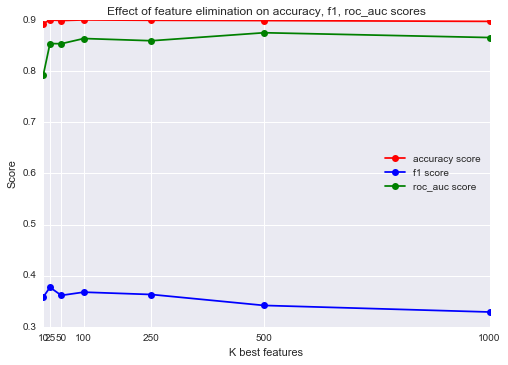

In [28]:
param_dist = {"randomforestclassifier__n_estimators": sp_randint(10,101),
              "randomforestclassifier__criterion": ["gini", "entropy"],
              "randomforestclassifier__max_features": ['auto', 'sqrt', 'log2']}
rseed = np.random.seed(22)

rf_args = {'random_state':rseed}
n_features_list = [10,25,50,100,250,500,1000]
rf_clf = tuned_estimators(RandomForestClassifier,X_train.as_matrix(),y_train.as_matrix(),X_test.as_matrix(),y_test.as_matrix()
                           ,param_dist,n_features_list,ncv=5,njobs=5,scoring_method='roc_auc',verbose=True,**rf_args)

In [29]:
rf_clf.keys()

dict_keys(['clf_k10', 'clf_k500', 'clf_k1000', 'clf_k250', 'clf_k100', 'clf_k25', 'clf_k50'])

In [40]:
from sklearn.externals import joblib
joblib.dump(rf_clf['clf_k100'], 'rfk100.pkl',compress = 1);

The random forest model with 100 best features had the best performance. The following provides the `confusion matrix`, `classification report` and `ROC curve` for `clf_k100`.

In [41]:
Summary_Results(rf_clf['clf_k100'],X_test.as_matrix(),y_test.as_matrix())

The accuracy is: 0.903 

Confusion_matrix:
		 pridicted values
		 0 	 1
actual 0:  	 15889 	 113
values 1:  	 1713 	 531
-------------------------------------------------------
Classification_report: 

             precision    recall  f1-score   support

    class 0       0.90      0.99      0.95     16002
    class 1       0.82      0.24      0.37      2244

avg / total       0.89      0.90      0.87     18246



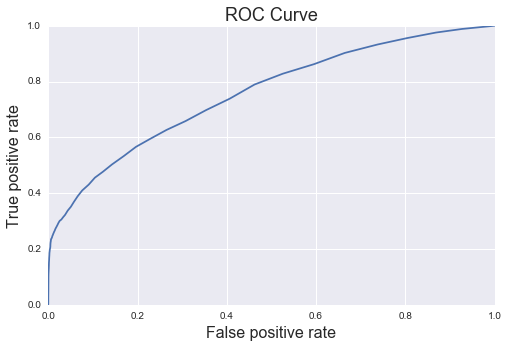

In [42]:
plot_roc_curve(rf_clf['clf_k100'],X_test.as_matrix(),y_test.as_matrix())

Best validation score: 0.7441


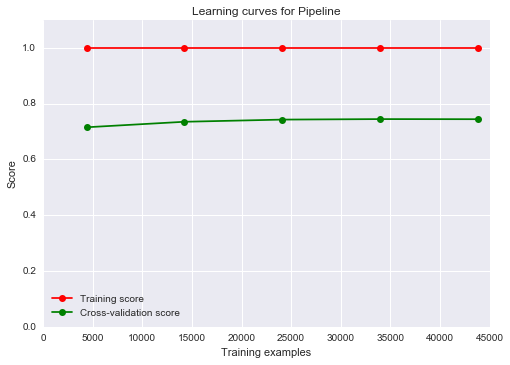

In [31]:
plot_learning_curve(rf_clf['clf_k100'], X_train.as_matrix(), y_train.as_matrix(), scoring='roc_auc')

### AdaBoost

10 best features: accuracy=0.8938, f1=0.3400, roc_auc=0.8114
25 best features: accuracy=0.8948, f1=0.3540, roc_auc=0.8122
50 best features: accuracy=0.8947, f1=0.3511, roc_auc=0.8129
100 best features: accuracy=0.8947, f1=0.3489, roc_auc=0.8144
250 best features: accuracy=0.8949, f1=0.3526, roc_auc=0.8149
500 best features: accuracy=0.8951, f1=0.3551, roc_auc=0.8150
1000 best features: accuracy=0.8946, f1=0.3510, roc_auc=0.8124


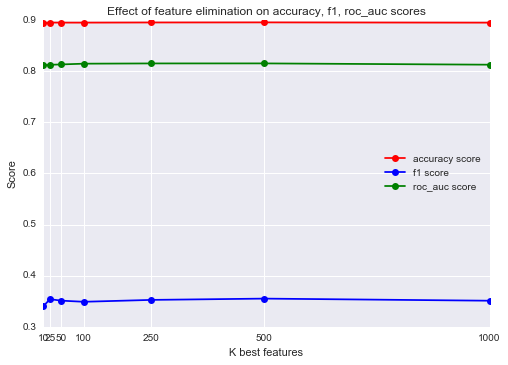

In [43]:
from sklearn.ensemble import AdaBoostClassifier

adaboost_args = {'random_state':rseed}
param_dist = {'adaboostclassifier__n_estimators': sp_randint(10,101), 
              'adaboostclassifier__learning_rate': [0.0001,0.001,0.01,0.1,1.0,2.0]}

n_features_list = [10,25,50,100,250,500,1000]
clf = AdaBoostClassifier(random_state= rseed)

adb_clf = tuned_estimators(clf,X_train.as_matrix(),y_train.as_matrix(),X_test.as_matrix(),y_test.as_matrix()
                           ,param_dist,n_features_list,ncv=5,njobs=5,scoring_method='roc_auc',verbose=True)

In [44]:
Summary_Results(adb_clf['clf_k500'],X_test.as_matrix(),y_test.as_matrix())

The accuracy is: 0.903 

Confusion_matrix:
		 pridicted values
		 0 	 1
actual 0:  	 15805 	 197
values 1:  	 1717 	 527
-------------------------------------------------------
Classification_report: 

             precision    recall  f1-score   support

    class 0       0.90      0.99      0.94     16002
    class 1       0.73      0.23      0.36      2244

avg / total       0.88      0.90      0.87     18246



In [45]:
joblib.dump(adb_clf['clf_k500'], 'adbk500.pkl',compress = 1);

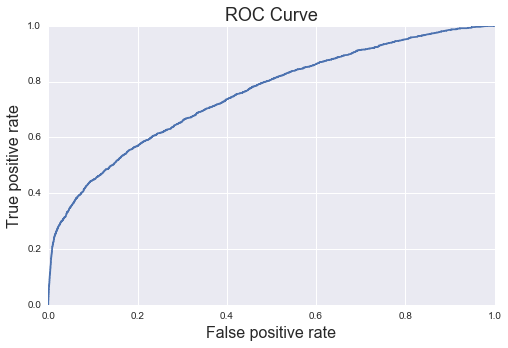

In [34]:
plot_roc_curve(adb_clf['clf_k500'],X_test.as_matrix(),y_test.as_matrix())

Best validation score: 0.7552


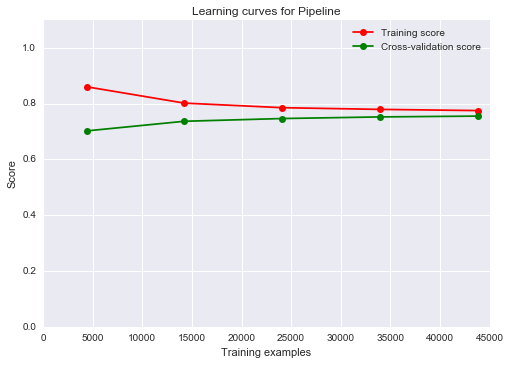

In [35]:
plot_learning_curve(adb_clf['clf_k500'], X_train.as_matrix(), y_train.as_matrix(), scoring='roc_auc')

#### Enforcing max depth = 5

10 best features: accuracy=0.8965, f1=0.3676, roc_auc=0.8210
25 best features: accuracy=0.9003, f1=0.3610, roc_auc=0.8765
50 best features: accuracy=0.9009, f1=0.3655, roc_auc=0.8803
100 best features: accuracy=0.9013, f1=0.3634, roc_auc=0.8903
250 best features: accuracy=0.9013, f1=0.3665, roc_auc=0.8861
500 best features: accuracy=0.9022, f1=0.3730, roc_auc=0.8918
1000 best features: accuracy=0.9015, f1=0.3638, roc_auc=0.8926


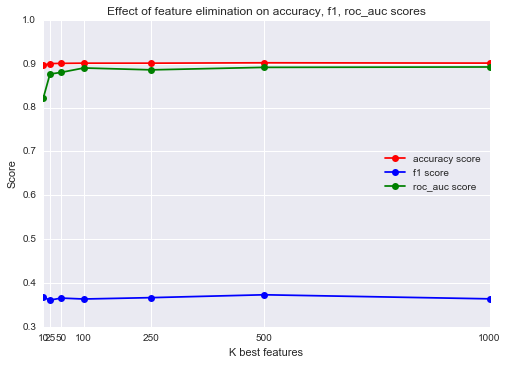

In [46]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

rseed = np.random.seed(22)

adaboost_args = {'random_state':rseed}
param_dist = {'adaboostclassifier__n_estimators': sp_randint(10,101), 
              'adaboostclassifier__learning_rate': [0.0001,0.001,0.01,0.1,1.0,2.0]}

clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5, random_state= rseed),random_state= rseed)

n_features_list = [10,25,50,100,250,500,1000]
adb_clf_depth5 = tuned_estimators(clf,X_train.as_matrix(),y_train.as_matrix(),X_test.as_matrix(),y_test.as_matrix()
                           ,param_dist,n_features_list,ncv=5,njobs=6,scoring_method='roc_auc',verbose=True)

In [47]:
joblib.dump(adb_clf_depth5['clf_k500'], 'adb_d5_k500.pkl',compress = 1);

In [41]:
from sklearn.externals import joblib
adb_d5_k500 = joblib.load('./adb_d5_k500.pkl')

In [42]:
Summary_Results(adb_d5_k500,X_test.as_matrix(),y_test.as_matrix())

The accuracy is: 0.903 

Confusion_matrix:
		 pridicted values
		 0 	 1
actual 0:  	 15930 	 72
values 1:  	 1713 	 531
-------------------------------------------------------
Classification_report: 

             precision    recall  f1-score   support

    class 0       0.90      1.00      0.95     16002
    class 1       0.88      0.24      0.37      2244

avg / total       0.90      0.90      0.88     18246



Best validation score: 0.7527


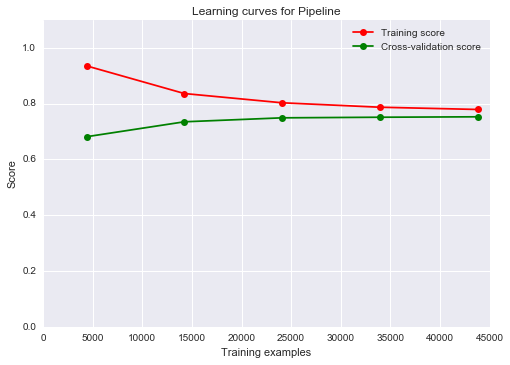

In [37]:
plot_learning_curve(adb_clf_depth5['clf_k500'], X_train.as_matrix(), y_train.as_matrix(), scoring='roc_auc')

### Adaboost maxdepth= 3

10 best features: accuracy=0.8958, f1=0.3681, roc_auc=0.8133
25 best features: accuracy=0.8992, f1=0.3584, roc_auc=0.8628
50 best features: accuracy=0.8990, f1=0.3491, roc_auc=0.8720
100 best features: accuracy=0.9006, f1=0.3641, roc_auc=0.8786
250 best features: accuracy=0.8998, f1=0.3568, roc_auc=0.8747
500 best features: accuracy=0.9007, f1=0.3647, roc_auc=0.8788
1000 best features: accuracy=0.9011, f1=0.3679, roc_auc=0.8816


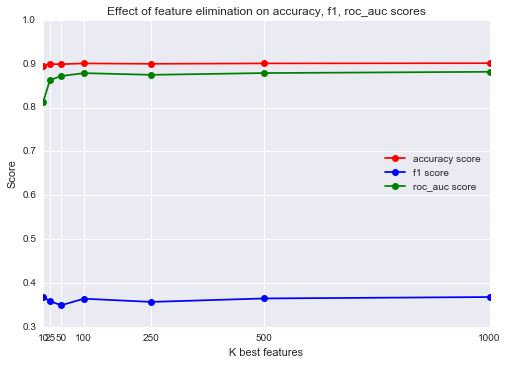

In [38]:
adaboost_args = {'random_state':rseed}
param_dist = {'adaboostclassifier__n_estimators': sp_randint(10,101), 
              'adaboostclassifier__learning_rate': [0.0001,0.001,0.01,0.1,1.0,2.0]}

clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3, random_state= rseed),random_state= rseed)

n_features_list = [10,25,50,100,250,500,1000]
adb_clf_depth3 = tuned_estimators(clf,X_train.as_matrix(),y_train.as_matrix(),X_test.as_matrix(),y_test.as_matrix()
                           ,param_dist,n_features_list,ncv=5,njobs=6,scoring_method='roc_auc',verbose=True)

In [ ]:
plot_learning_curve(adb_clf_depth3['clf_k1000'], X_train.as_matrix(), y_train.as_matrix(), scoring='roc_auc')

#### stacked generalization classifier (RandomForest - ExtraTreeClassifier - LogisticRegression)

In [49]:
from stacked_generalizer import StackedGeneralizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression


base_models = [rf_clf['clf_k100'],
               adb_clf_depth5['clf_k500'],
               ExtraTreesClassifier(n_estimators=100, n_jobs=4, criterion='gini')]

blending_model = LogisticRegression()

sg = StackedGeneralizer(base_models, blending_model,n_folds=5, verbose=True)
sg.fit(X_train.as_matrix(),y_train.as_matrix())

Fitting Base Models...
Fitting model 01: Pipeline(steps=[('selectkbest', SelectKBest(k=100, score_func=<function f_classif at 0x0000000012687378>)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=84, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fitting model 02: Pipeline(steps=[('selectkbest', SelectKBest(k=500, score_func=<function f_classif at 0x0000000012687378>)), ('adaboostclassifier', AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_...dom_state=None, splitter='best'),
          learning_rate=0.1, n_estimators=18, random_state=Non

In [50]:
pred = sg.predict(X_test.as_matrix())
pred_classes = [np.argmax(p) for p in pred]
_ = sg.evaluate(y_test.as_matrix(), pred_classes)

             precision    recall  f1-score   support

          0       0.90      0.99      0.94     16002
          1       0.80      0.23      0.36      2244

avg / total       0.89      0.90      0.87     18246

Confusion Matrix:
[[15873   129]
 [ 1723   521]]


### Over-sampling the minority class:

**SMOTE**

In [ ]:

from imblearn.over_sampling import SMOTE
ratio = 'auto'
verbose = True
smote = SMOTE(ratio=ratio, kind='regular')
smox, smoy = smote.fit_sample(X_train.as_matrix(), y_train.as_matrix())

In [40]:
from sklearn.decomposition import PCA

X_pca = PCA(n_components=2).fit_transform(X_train.as_matrix())
X_pca_regular_smooth = PCA(n_components=2).fit_transform(smox)

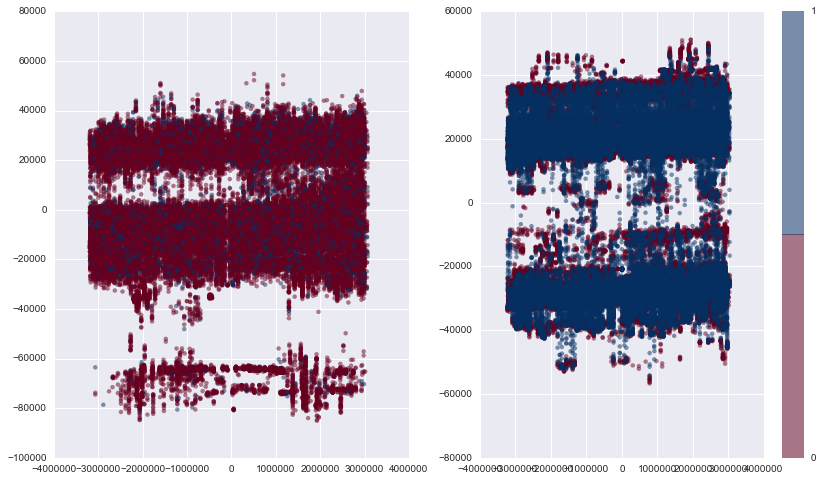

In [41]:
plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, edgecolor='none', alpha=0.5, 
            cmap=plt.cm.get_cmap('RdBu', 2))
plt.subplot(1,2,2)
plt.scatter(X_pca_regular_smooth[:, 0], X_pca_regular_smooth[:, 1], c=smoy, edgecolor='none', alpha=0.5, 
            cmap=plt.cm.get_cmap('RdBu', 2))
plt.colorbar(ticks=range(2));

In [ ]:
rseed = np.random.seed(22)

adaboost_args = {'random_state':rseed}
param_dist = {'adaboostclassifier__n_estimators': sp_randint(10,101), 
              'adaboostclassifier__learning_rate': [0.0001,0.001,0.01,0.1,1.0,2.0]}

clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5, random_state= rseed),random_state= rseed)

n_features_list = [10,25,50,100,250,500,1000]
adb_clf_depth5_upscale = tuned_estimators(clf,smox,smoy,X_test.as_matrix(),y_test.as_matrix()
                           ,param_dist,n_features_list,ncv=5,njobs=6,scoring_method='roc_auc',verbose=True)

10 best features: accuracy=0.8959, f1=0.3692, roc_auc=0.8137
25 best features: accuracy=0.8990, f1=0.3648, roc_auc=0.8545
50 best features: accuracy=0.8999, f1=0.3624, roc_auc=0.8696
100 best features: accuracy=0.9010, f1=0.3715, roc_auc=0.8746
250 best features: accuracy=0.8998, f1=0.3643, roc_auc=0.8651


**SMOTE_ENN**

In [14]:
from imblearn.combine import SMOTEENN
ratio = 'auto'
verbose = True

# 'SMOTE ENN'
SENN = SMOTEENN(ratio=ratio)
ennx, enny = SENN.fit_sample(X_train.as_matrix(), y_train.as_matrix())

In [15]:
from sklearn.decomposition import PCA

X_pca = PCA(n_components=2).fit_transform(X_train.as_matrix())
X_pca_senn = PCA(n_components=2).fit_transform(ennx)

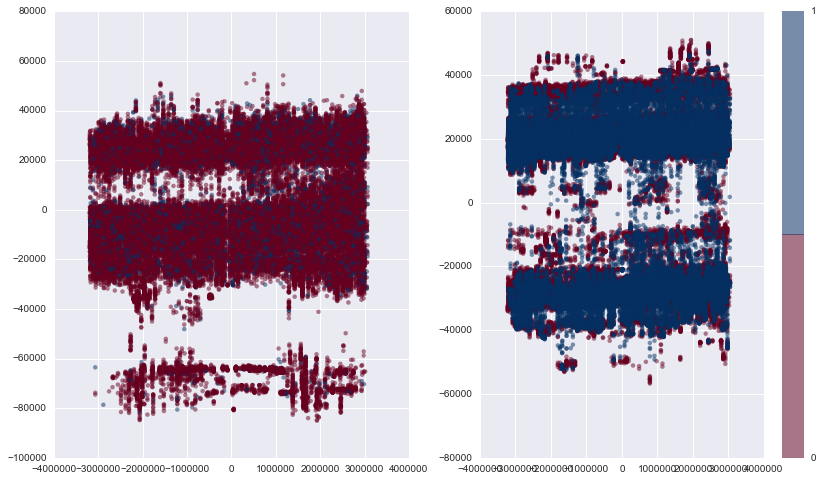

In [17]:
plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, edgecolor='none', alpha=0.5, 
            cmap=plt.cm.get_cmap('RdBu', 2))
plt.subplot(1,2,2)
plt.scatter(X_pca_senn[:, 0], X_pca_senn[:, 1], c=enny, edgecolor='none', alpha=0.5, 
            cmap=plt.cm.get_cmap('RdBu', 2))
plt.colorbar(ticks=range(2));

10 best features: accuracy=0.8959, f1=0.3685, roc_auc=0.8147
25 best features: accuracy=0.8994, f1=0.3595, roc_auc=0.8656
50 best features: accuracy=0.8999, f1=0.3560, roc_auc=0.8765
100 best features: accuracy=0.9001, f1=0.3570, roc_auc=0.8789
250 best features: accuracy=0.8992, f1=0.3507, roc_auc=0.8717
500 best features: accuracy=0.8997, f1=0.3570, roc_auc=0.8727
1000 best features: accuracy=0.9012, f1=0.3707, roc_auc=0.8789


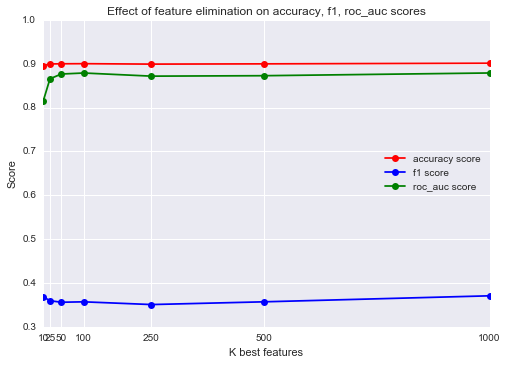

In [26]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
rseed = np.random.seed(22)

adaboost_args = {'random_state':rseed}
param_dist = {'adaboostclassifier__n_estimators': sp_randint(10,101), 
              'adaboostclassifier__learning_rate': [0.0001,0.001,0.01,0.1,1.0,2.0]}

clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5, random_state= rseed),random_state= rseed)

n_features_list = [10,25,50,100,250,500,1000]
adb_clf_depth5_upsmpl_enn = tuned_estimators(clf,ennx,enny,X_test.as_matrix(),y_test.as_matrix()
                           ,param_dist,n_features_list,ncv=5,njobs=6,scoring_method='roc_auc',verbose=True)

In [27]:
from sklearn.externals import joblib
joblib.dump(adb_clf_depth5_upsmpl_enn['clf_k1000'], 'adb_enn_k1000.pkl',compress = 1);

Best validation score: 0.7492


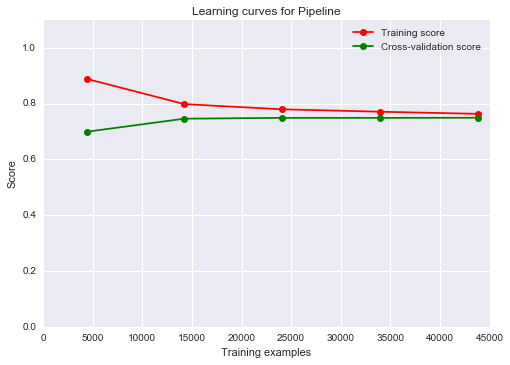

In [29]:
plot_learning_curve(adb_clf_depth5_upsmpl_enn['clf_k1000'], X_train.as_matrix(), y_train.as_matrix(), scoring='roc_auc')

In [43]:
clf_soft_enn = joblib.load('./adb_enn_k1000.pkl')
Summary_Results(clf_soft_enn,X_test.as_matrix(),y_test.as_matrix())

The accuracy is: 0.903 

Confusion_matrix:
		 pridicted values
		 0 	 1
actual 0:  	 15912 	 90
values 1:  	 1713 	 531
-------------------------------------------------------
Classification_report: 

             precision    recall  f1-score   support

    class 0       0.90      0.99      0.95     16002
    class 1       0.86      0.24      0.37      2244

avg / total       0.90      0.90      0.88     18246



### ExtraTreeClassifier

10 best features: accuracy=0.8869, f1=0.3511, roc_auc=0.7497
25 best features: accuracy=0.8974, f1=0.3705, roc_auc=0.8291
50 best features: accuracy=0.8961, f1=0.3552, roc_auc=0.8265
100 best features: accuracy=0.8969, f1=0.3625, roc_auc=0.8291
250 best features: accuracy=0.8943, f1=0.3429, roc_auc=0.8149
500 best features: accuracy=0.8956, f1=0.3329, roc_auc=0.8392
1000 best features: accuracy=0.8922, f1=0.3002, roc_auc=0.8206


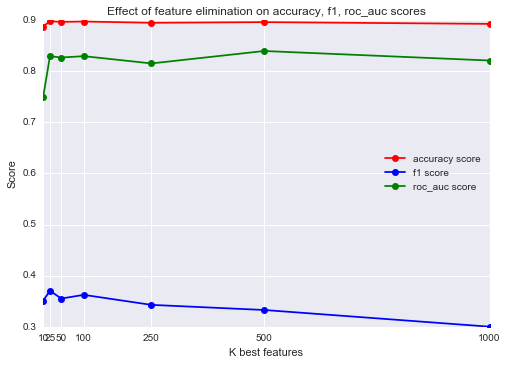

In [30]:
from sklearn.ensemble import ExtraTreesClassifier

param_dist = {"extratreesclassifier__n_estimators": sp_randint(10,101),
              "extratreesclassifier__criterion": ["gini", "entropy"],
              "extratreesclassifier__max_features": ['auto', 'sqrt', 'log2']}

clf = ExtraTreesClassifier(random_state= rseed)

n_features_list = [10,25,50,100,250,500,1000]
etc_clf = tuned_estimators(clf,X_train.as_matrix(),y_train.as_matrix(),X_test.as_matrix(),y_test.as_matrix()
                           ,param_dist,n_features_list,ncv=5,njobs=6,scoring_method='roc_auc',verbose=True)

In [28]:
joblib.load('./rfk100.pkl')

Pipeline(steps=[('selectkbest', SelectKBest(k=100, score_func=<function f_classif at 0x000000000F8DE048>)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=84, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [46]:
joblib.load('adb_d5_k500.pkl')

Pipeline(steps=[('selectkbest', SelectKBest(k=500, score_func=<function f_classif at 0x00000000107F9950>)), ('adaboostclassifier', AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_...dom_state=None, splitter='best'),
          learning_rate=0.1, n_estimators=18, random_state=None))])

<Container object of 100 artists>

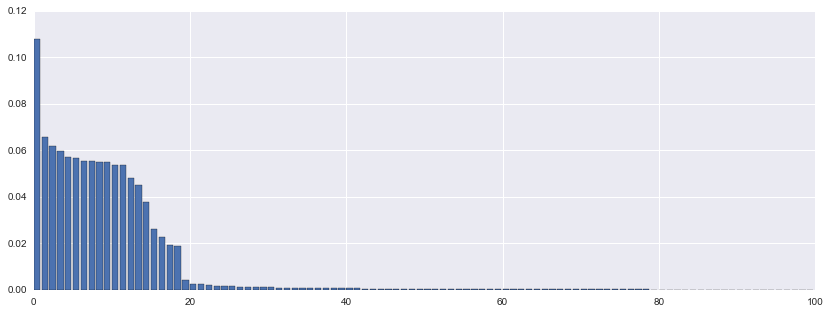

In [32]:
from sklearn.externals import joblib
rf_k100 = joblib.load('./rfk100.pkl')
importances = rf_k100.steps[1][1].feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(14,5))
plt.bar(range(len(importances)),importances[indices])

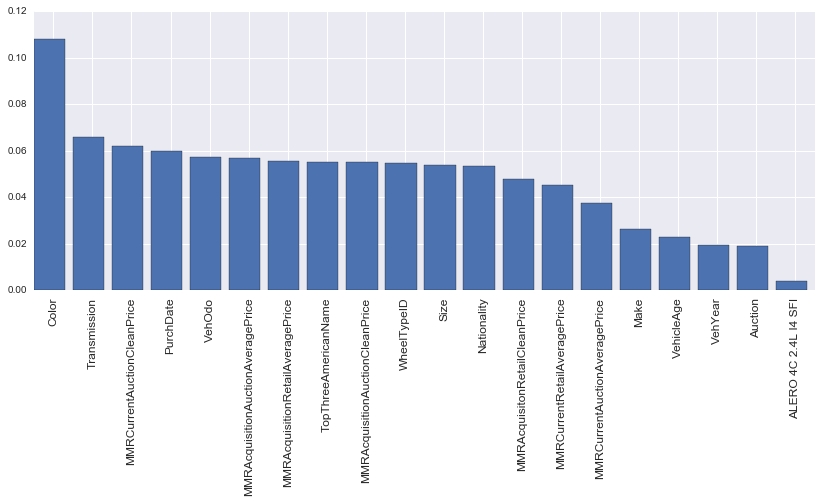

In [33]:
plt.figure(figsize=(14,5))
plt.bar(range(len(importances[indices[:20]])),importances[indices[:20]])
indices = np.argsort(importances)[::-1]
labels = list(X_train.columns[indices[:20]])
plt.xticks(np.arange(20)+0.5,labels, rotation='90',fontsize = 12);

<Container object of 500 artists>

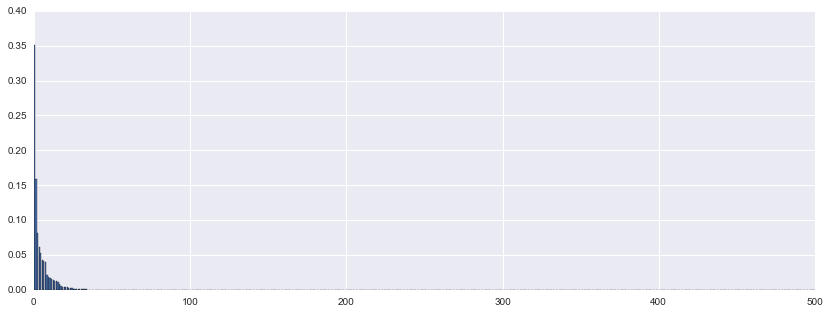

In [34]:
adb_k500 = joblib.load('adb_d5_k500.pkl')
importances = adb_k500.steps[1][1].feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(14,5))
plt.bar(range(len(importances)),importances[indices])

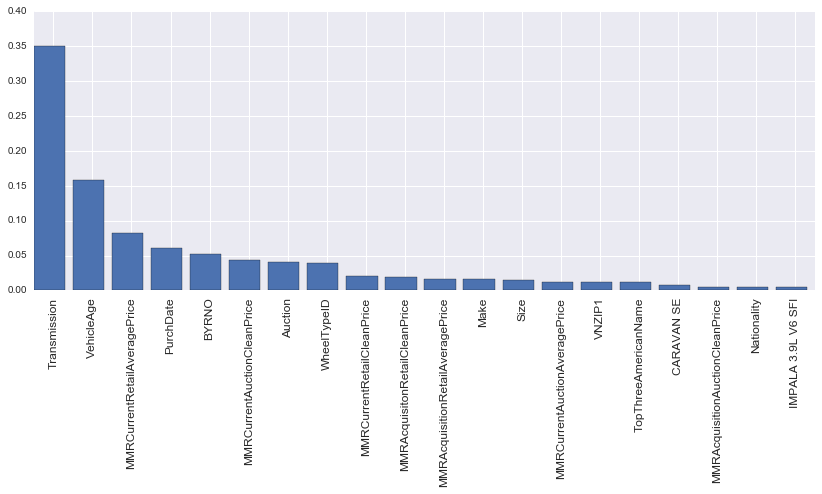

In [35]:
plt.figure(figsize=(14,5))
plt.bar(range(len(importances[indices[:20]])),importances[indices[:20]])
indices = np.argsort(importances)[::-1]
labels = list(X_train.columns[indices[:20]])
plt.xticks(np.arange(20)+0.5,labels, rotation='90',fontsize = 12);

In [54]:
yperd = joblib.load('adb_d5_k500.pkl').predict(X_test.as_matrix())

In [74]:
df= pd.DataFrame([X_test.VehBCost[y_test==1].sum(),X_test.VehBCost[(y_test==1) & (yperd==1)].sum()],index = ['without model','with model'])
print(df)

                         0
without model  14079089.26
with model      3407934.27


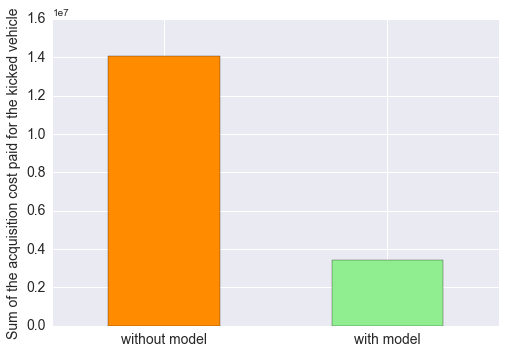

In [84]:
df.plot.bar(legend=False, fontsize=14, rot=0, color=['darkorange','lightgreen']);
plt.ylabel('Sum of the acquisition cost paid for the kicked vehicle',fontsize=14)

In [73]:
X_test.VehBCost[y_test==1].sum()

14079089.26

In [71]:
X_test.VehBCost[(y_test==1) & (yperd==1)].sum()

3407934.27

In [72]:
X_test.VehBCost.sum()

122578037.50999999